# JHARKHAND


In [238]:
import pandas as pd

# 1. Load the three Jharkhand datasets
df_jk_enrolment = pd.read_csv('/content/Jharkhand Enrolment State.csv')
df_jk_demographic = pd.read_csv('/content/Jharkhand Demographic State.csv')
df_jk_biometric = pd.read_csv('/content/Jharkhand Biometric State.csv')

# 4. Convert the 'date' column in df_jk_enrolment to datetime objects
df_jk_enrolment['date'] = pd.to_datetime(df_jk_enrolment['date'], format='%d-%m-%Y')

# 5. Convert the 'date' column in df_jk_demographic to datetime objects
df_jk_demographic['date'] = pd.to_datetime(df_jk_demographic['date'], format='%d-%m-%Y')

# 6. Convert the 'date' column in df_jk_biometric to datetime objects
df_jk_biometric['date'] = pd.to_datetime(df_jk_biometric['date'], format='%d-%m-%Y')

# 7. Perform an outer merge of df_jk_enrolment and df_jk_demographic
merged_jk_df_temp = pd.merge(df_jk_enrolment, df_jk_demographic, on=['date', 'state', 'district', 'pincode'], how='outer')

# 8. Perform an outer merge of the temporary DataFrame and df_jk_biometric
df_merged_jk = pd.merge(merged_jk_df_temp, df_jk_biometric, on=['date', 'state', 'district', 'pincode'], how='outer')

# 9. Identify all numerical columns in df_merged_jk.
numeric_cols = df_merged_jk.select_dtypes(include=['number']).columns

# 10. Fill any NaN values in these identified numerical columns of df_merged_jk with 0.
df_merged_jk[numeric_cols] = df_merged_jk[numeric_cols].fillna(0)


print("Data loaded and merged successfully.")

Data loaded and merged successfully.


In [239]:
print("\nJharkhand Enrolment Dataset head:")
print(df_jk_enrolment.head())
print("\nJharkhand Demographic Dataset head:")
print(df_jk_demographic.head())
print("\nJharkhand Biometric Dataset head:")
print(df_jk_biometric.head())
print("\nMerged Jharkhand DataFrame (df_merged_jk) head:")
print(df_merged_jk.head())
print("\nMerged Jharkhand DataFrame (df_merged_jk) info:")
print(df_merged_jk.info())
print("\nMerged Jharkhand DataFrame (df_merged_jk) describe:")
print(df_merged_jk.describe())


Jharkhand Enrolment Dataset head:
        date      state district  pincode  age_0_5  age_5_17  age_18_greater
0 2025-09-01  Jharkhand   Bokaro   827009        1         5               0
1 2025-09-01  Jharkhand   Bokaro   828134        5         6               0
2 2025-09-01  Jharkhand   Bokaro   828303        2         1               0
3 2025-09-01  Jharkhand   Bokaro   829123        1         0               0
4 2025-09-01  Jharkhand  Deoghar   814112        2         3               0

Jharkhand Demographic Dataset head:
        date      state             district  pincode  demo_age_5_17  \
0 2025-03-01  Jharkhand              Ramgarh   829110             82   
1 2025-03-01  Jharkhand                Dumka   814146             44   
2 2025-03-01  Jharkhand              Koderma   825407             14   
3 2025-03-01  Jharkhand            Hazaribag   825312             22   
4 2025-03-01  Jharkhand  Seraikela-Kharsawan   832401             47   

   demo_age_17_  
0          2488

In [261]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Filter for Jharkhand state
df_jk = df_merged_jk[df_merged_jk['state'] == 'Jharkhand'].copy()
df_jk['year'] = df_jk['date'].dt.year
df_jk['month'] = df_jk['date'].dt.month

age_columns = ['age_0_5', 'age_5_17', 'age_18_greater', 'demo_age_5_17', 'demo_age_17_', 'bio_age_5_17', 'bio_age_17_']

# Aggregate data
df_jk_agg = df_jk.groupby(['year', 'month', 'state', 'district'])[age_columns].sum().reset_index()

# 1. Create 'totalenrolments' column
df_jk_agg['totalenrolments'] = df_jk_agg['age_0_5'] + df_jk_agg['age_5_17'] + df_jk_agg['age_18_greater']

# 2. Create 'childenrolments' column
df_jk_agg['childenrolments'] = df_jk_agg['age_0_5'] + df_jk_agg['age_5_17']

# 3. Create 'totaldemoupdates' column
df_jk_agg['totaldemoupdates'] = df_jk_agg['demo_age_5_17'] + df_jk_agg['demo_age_17_']

# 4. Create 'totalbioupdates' column
df_jk_agg['totalbioupdates'] = df_jk_agg['bio_age_5_17'] + df_jk_agg['bio_age_17_']

# 5. Calculate 'CES' (Child Enrolment Score) with division by zero handling
df_jk_agg['CES'] = np.where(
    df_jk_agg['totalenrolments'] == 0,
    0,
    df_jk_agg['childenrolments'] / df_jk_agg['totalenrolments']
)

# 6. Calculate 'DUR' (Demographic Update Rate) with division by zero handling
df_jk_agg['DUR'] = np.where(
    df_jk_agg['totalenrolments'] == 0,
    0,
    df_jk_agg['totaldemoupdates'] / df_jk_agg['totalenrolments']
)

# 7. Calculate 'BUR' (Biometric Update Rate) with division by zero handling
df_jk_agg['BUR'] = np.where(
    df_jk_agg['totalenrolments'] == 0,
    0,
    df_jk_agg['totalbioupdates'] / df_jk_agg['totalenrolments']
)

# --- Normalization and ALBI calculation ---
def min_max_normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return 0  # Handle division by zero case
    return (series - min_val) / (max_val - min_val)

# Apply min-max normalization to 'totalenrolments', grouped by 'year' and 'state'
df_jk_agg['Enorm'] = df_jk_agg.groupby(['year', 'state'])['totalenrolments'].transform(min_max_normalize)

# Apply min-max normalization to 'totaldemoupdates', grouped by 'year' and 'state'
df_jk_agg['Dnorm'] = df_jk_agg.groupby(['year', 'state'])['totaldemoupdates'].transform(min_max_normalize)

# Apply min-max normalization to 'totalbioupdates', grouped by 'year', 'month' and 'state'
df_jk_agg['Bnorm'] = df_jk_agg.groupby(['year', 'state'])['totalbioupdates'].transform(min_max_normalize)

# Calculate 'stdnorm' by combining the normalized metrics
df_jk_agg['stdnorm'] = (df_jk_agg['Enorm'] + df_jk_agg['Dnorm'] + df_jk_agg['Bnorm']) / 3

# Compute 'ALBI' (Aadhaar Lifecycle Balance Index) as 1 - stdnorm
df_jk_agg['ALBI'] = 1 - df_jk_agg['stdnorm']

# Clip the values in the 'ALBI' column to ensure they are between 0 and 1
df_jk_agg['ALBI'] = df_jk_agg['ALBI'].clip(lower=0, upper=1)

# --- Risk score calculation ---
df_jk_agg['Enormrisk'] = 1 - df_jk_agg['Enorm']
df_jk_agg['CESrisknorm'] = 1 - df_jk_agg['CES']
df_jk_agg['DURrisknorm'] = 1 - df_jk_agg['DUR']
df_jk_agg['BURrisknorm'] = 1 - df_jk_agg['BUR']
df_jk_agg['ALBIrisknorm'] = 1 - df_jk_agg['ALBI']

# Calculate the 'riskscore' by summing the risk components, averaging, and scaling to 0-100
df_jk_agg['riskscore'] = (
    df_jk_agg['Enormrisk'] +
    df_jk_agg['CESrisknorm'] +
    df_jk_agg['DURrisknorm'] +
    df_jk_agg['BURrisknorm'] +
    df_jk_agg['ALBIrisknorm']
) / 5 * 100

In [262]:
def min_max_normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return 0  # Handle division by zero case
    return (series - min_val) / (max_val - min_val)

# Apply min-max normalization to 'totalenrolments', grouped by 'year' and 'state'
df_jk_agg['Enorm'] = df_jk_agg.groupby(['year', 'state'])['totalenrolments'].transform(min_max_normalize)

# Apply min-max normalization to 'totaldemoupdates', grouped by 'year' and 'state'
df_jk_agg['Dnorm'] = df_jk_agg.groupby(['year', 'state'])['totaldemoupdates'].transform(min_max_normalize)

# Apply min-max normalization to 'totalbioupdates', grouped by 'year', 'month' and 'state'
df_jk_agg['Bnorm'] = df_jk_agg.groupby(['year', 'state'])['totalbioupdates'].transform(min_max_normalize)

# Calculate 'stdnorm' by combining the normalized metrics
df_jk_agg['stdnorm'] = (df_jk_agg['Enorm'] + df_jk_agg['Dnorm'] + df_jk_agg['Bnorm']) / 3

# Compute 'ALBI' (Aadhaar Lifecycle Balance Index) as 1 - stdnorm
df_jk_agg['ALBI'] = 1 - df_jk_agg['stdnorm']

# Clip the values in the 'ALBI' column to ensure they are between 0 and 1
df_jk_agg['ALBI'] = df_jk_agg['ALBI'].clip(lower=0, upper=1)

# Display the head of the DataFrame to show the newly created columns
print("Aggregated DataFrame (df_jk_agg) with normalized metrics and ALBI head:")
print(df_jk_agg.head())

Aggregated DataFrame (df_jk_agg) with normalized metrics and ALBI head:
   year  month      state district  age_0_5  age_5_17  age_18_greater  \
0  2025      3  Jharkhand   Bokaro      0.0       0.0             0.0   
1  2025      3  Jharkhand   Chatra      0.0       0.0             0.0   
2  2025      3  Jharkhand  Deoghar     12.0      25.0            18.0   
3  2025      3  Jharkhand  Dhanbad      0.0       0.0             0.0   
4  2025      3  Jharkhand    Dumka      0.0       0.0             0.0   

   demo_age_5_17  demo_age_17_  bio_age_5_17  ...     Dnorm     Bnorm  \
0          823.0       37376.0        3629.0  ...  0.758248  0.305285   
1          752.0       15325.0        5091.0  ...  0.319127  0.311446   
2          723.0       23244.0        5230.0  ...  0.475743  0.282876   
3         1241.0       39920.0        7080.0  ...  0.817043  0.619914   
4          826.0       19417.0        8376.0  ...  0.401822  0.393228   

    stdnorm      ALBI  Enormrisk  CESrisknorm  DUR

In [263]:
df_jk_agg['Enormrisk'] = 1 - df_jk_agg['Enorm']
df_jk_agg['CESrisknorm'] = 1 - df_jk_agg['CES']
df_jk_agg['DURrisknorm'] = 1 - df_jk_agg['DUR']
df_jk_agg['BURrisknorm'] = 1 - df_jk_agg['BUR']
df_jk_agg['ALBIrisknorm'] = 1 - df_jk_agg['ALBI']

# Calculate the 'riskscore' by summing the risk components, averaging, and scaling to 0-100
df_jk_agg['riskscore'] = (
    df_jk_agg['Enormrisk'] +
    df_jk_agg['CESrisknorm'] +
    df_jk_agg['DURrisknorm'] +
    df_jk_agg['BURrisknorm'] +
    df_jk_agg['ALBIrisknorm']
) / 5 * 100

# Display the head of the DataFrame to show the newly created risk-related columns
print("Aggregated DataFrame (df_jk_agg) with risk components and riskscore head:")
print(df_jk_agg.head())

Aggregated DataFrame (df_jk_agg) with risk components and riskscore head:
   year  month      state district  age_0_5  age_5_17  age_18_greater  \
0  2025      3  Jharkhand   Bokaro      0.0       0.0             0.0   
1  2025      3  Jharkhand   Chatra      0.0       0.0             0.0   
2  2025      3  Jharkhand  Deoghar     12.0      25.0            18.0   
3  2025      3  Jharkhand  Dhanbad      0.0       0.0             0.0   
4  2025      3  Jharkhand    Dumka      0.0       0.0             0.0   

   demo_age_5_17  demo_age_17_  bio_age_5_17  ...     Dnorm     Bnorm  \
0          823.0       37376.0        3629.0  ...  0.758248  0.305285   
1          752.0       15325.0        5091.0  ...  0.319127  0.311446   
2          723.0       23244.0        5230.0  ...  0.475743  0.282876   
3         1241.0       39920.0        7080.0  ...  0.817043  0.619914   
4          826.0       19417.0        8376.0  ...  0.401822  0.393228   

    stdnorm      ALBI  Enormrisk  CESrisknorm  D

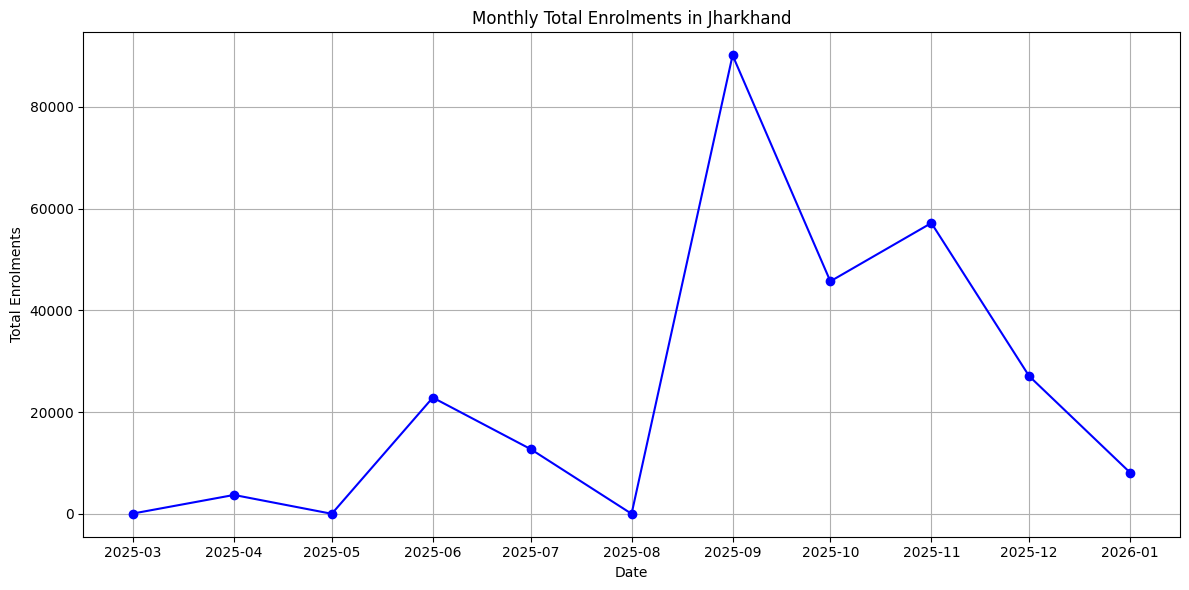

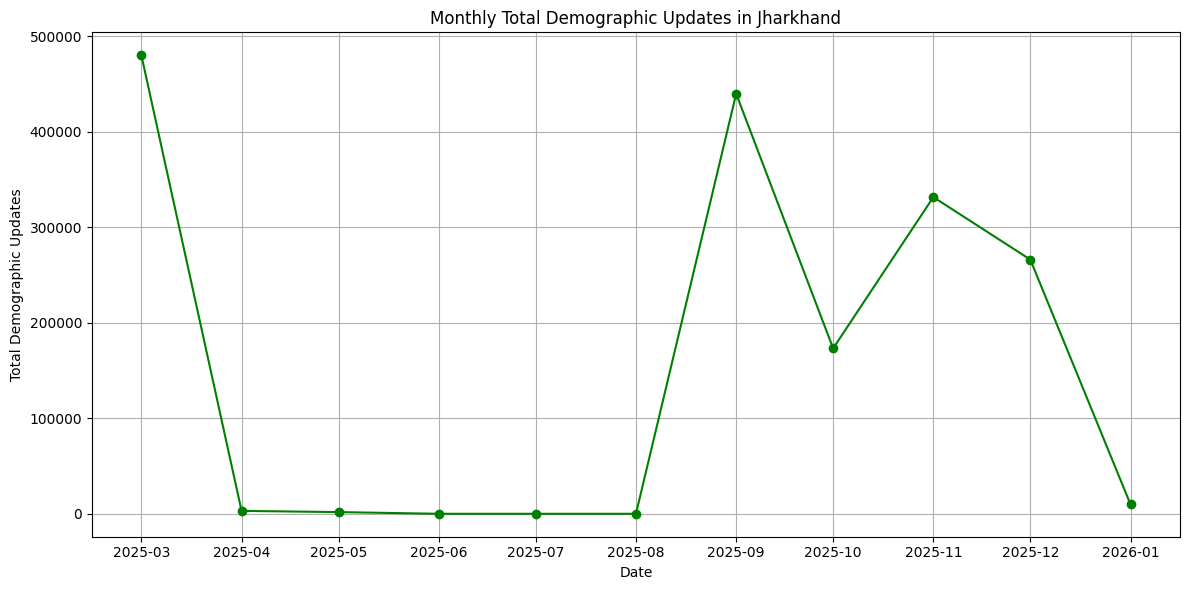

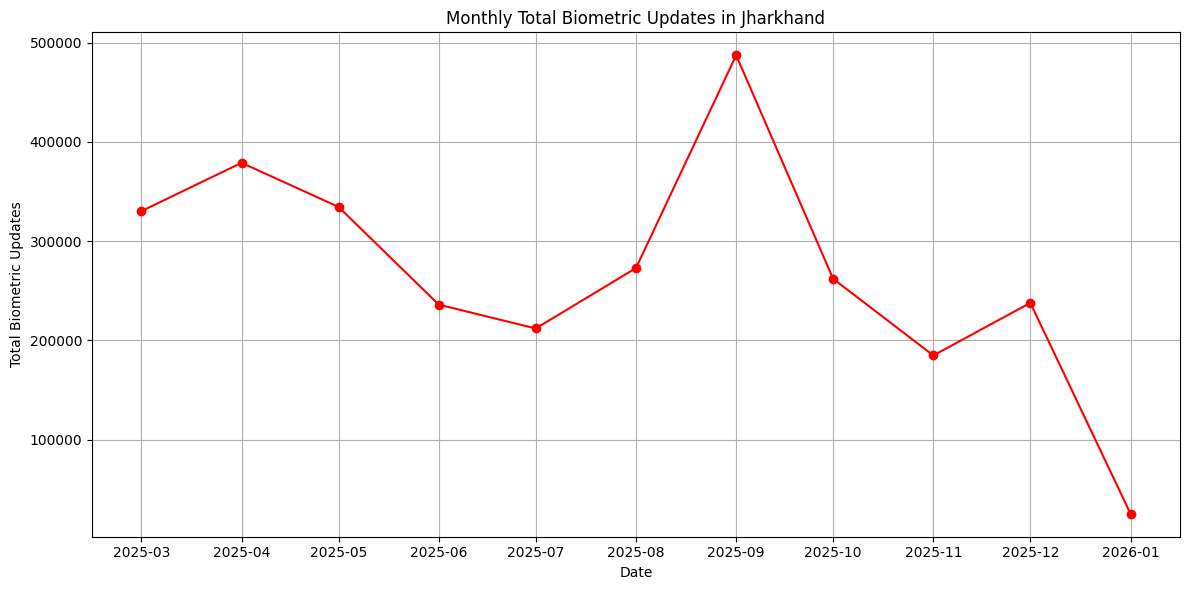

Monthly trend plots generated successfully.


In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

df_jk_monthly_trends = df_jk_agg.groupby(['year', 'month']).agg({
    'totalenrolments': 'sum',
    'totaldemoupdates': 'sum',
    'totalbioupdates': 'sum'
}).reset_index()

# Create a date column for plotting
df_jk_monthly_trends['date'] = pd.to_datetime(df_jk_monthly_trends['year'].astype(str) + '-' + df_jk_monthly_trends['month'].astype(str) + '-01')

# Sort by date to ensure proper trend plotting
df_jk_monthly_trends = df_jk_monthly_trends.sort_values(by='date')

# Plotting totalenrolments monthly trend
plt.figure(figsize=(12, 6))
plt.plot(df_jk_monthly_trends['date'], df_jk_monthly_trends['totalenrolments'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Enrolments')
plt.title('Monthly Total Enrolments in Jharkhand')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting totaldemoupdates monthly trend
plt.figure(figsize=(12, 6))
plt.plot(df_jk_monthly_trends['date'], df_jk_monthly_trends['totaldemoupdates'], marker='o', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Total Demographic Updates')
plt.title('Monthly Total Demographic Updates in Jharkhand')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting totalbioupdates monthly trend
plt.figure(figsize=(12, 6))
plt.plot(df_jk_monthly_trends['date'], df_jk_monthly_trends['totalbioupdates'], marker='o', linestyle='-', color='red')
plt.xlabel('Date')
plt.ylabel('Total Biometric Updates')
plt.title('Monthly Total Biometric Updates in Jharkhand')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Monthly trend plots generated successfully.")

**Univariate Analysis**

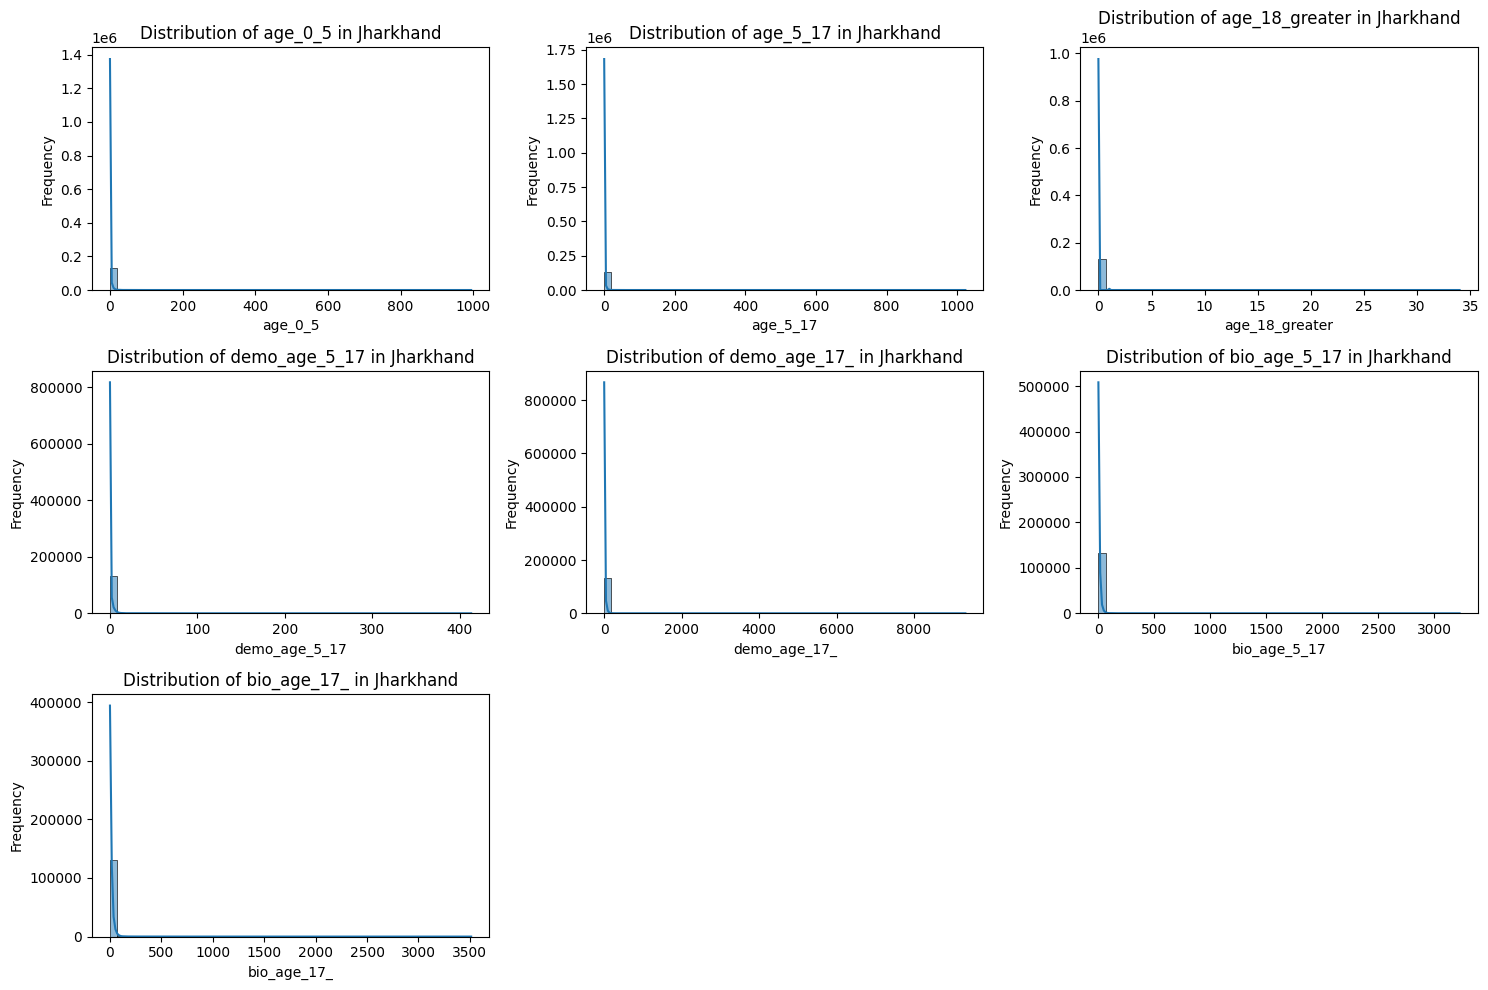

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['age_0_5', 'age_5_17', 'age_18_greater', 'demo_age_5_17', 'demo_age_17_', 'bio_age_5_17', 'bio_age_17_']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1) # Adjust subplot grid based on number of columns
    sns.histplot(df_merged_jk[col], bins=50, kde=True)
    plt.title(f'Distribution of {col} in Jharkhand')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

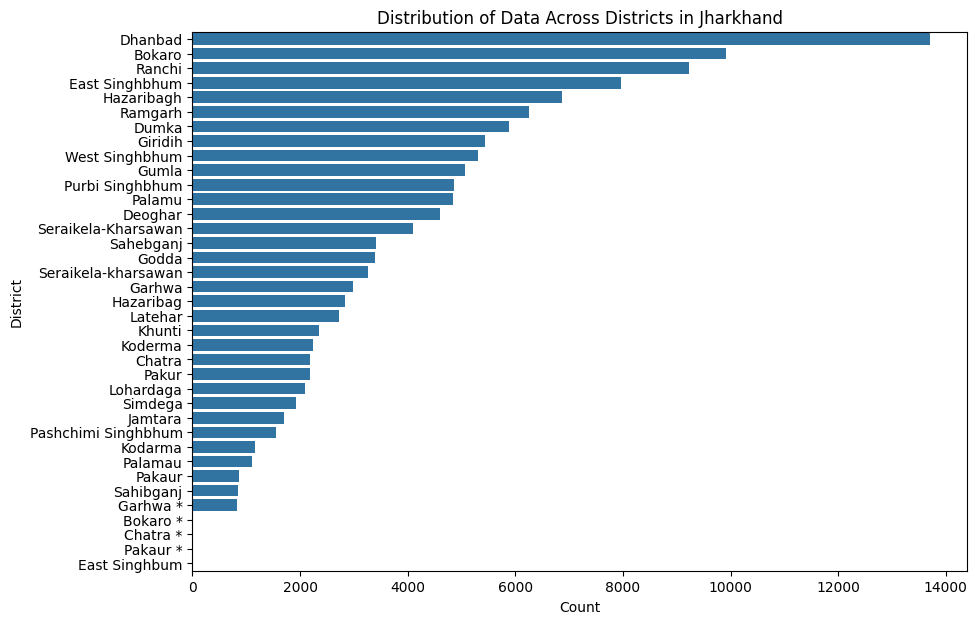

Histograms for numerical age-related columns and count plot for 'district' displayed for Jharkhand.


In [266]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df_merged_jk, y='district', order=df_merged_jk['district'].value_counts().index)
plt.title('Distribution of Data Across Districts in Jharkhand')
plt.xlabel('Count')
plt.ylabel('District')
plt.show()

print("Histograms for numerical age-related columns and count plot for 'district' displayed for Jharkhand.")

**Bivariate and Trivariate Analysis**

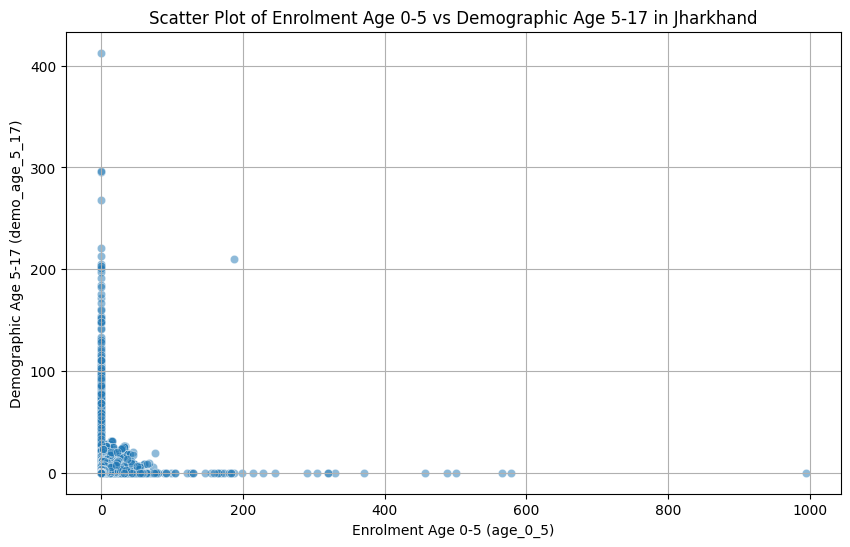

In [267]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged_jk, x='age_0_5', y='demo_age_5_17', alpha=0.5)
plt.title('Scatter Plot of Enrolment Age 0-5 vs Demographic Age 5-17 in Jharkhand')
plt.xlabel('Enrolment Age 0-5 (age_0_5)')
plt.ylabel('Demographic Age 5-17 (demo_age_5_17)')
plt.grid(True)
plt.show()

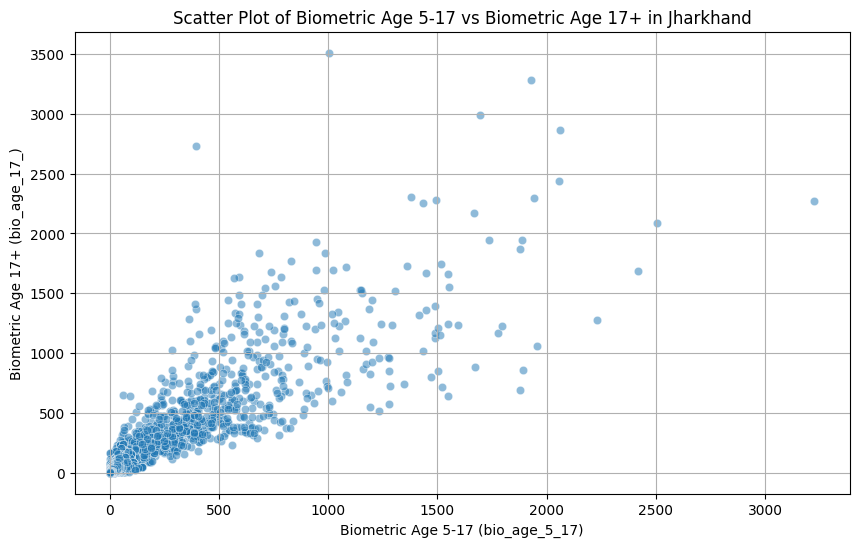

Scatter plots for age-related columns displayed for Jharkhand.


In [268]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged_jk, x='bio_age_5_17', y='bio_age_17_', alpha=0.5)
plt.title('Scatter Plot of Biometric Age 5-17 vs Biometric Age 17+ in Jharkhand')
plt.xlabel('Biometric Age 5-17 (bio_age_5_17)')
plt.ylabel('Biometric Age 17+ (bio_age_17_)')
plt.grid(True)
plt.show()

print("Scatter plots for age-related columns displayed for Jharkhand.")

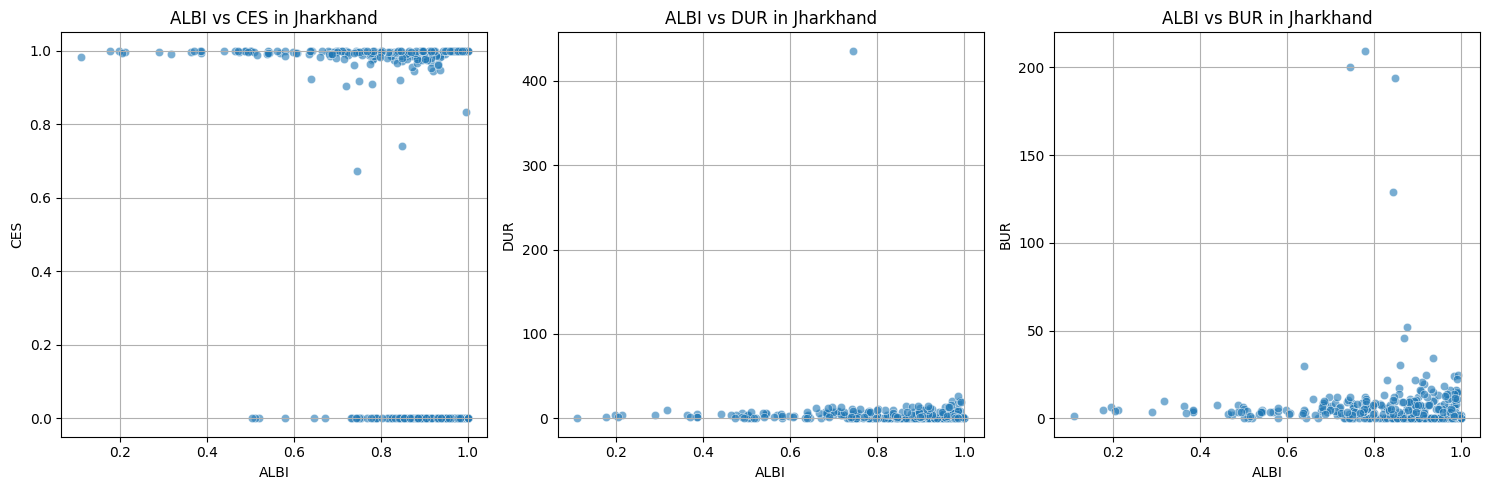

In [269]:
# --- Plotting code ---
metrics_for_albi_scatter = ['CES', 'DUR', 'BUR']

plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics_for_albi_scatter):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(data=df_jk_agg, x='ALBI', y=metric, alpha=0.6)
    plt.title(f'ALBI vs {metric} in Jharkhand')
    plt.xlabel('ALBI')
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
plt.show()

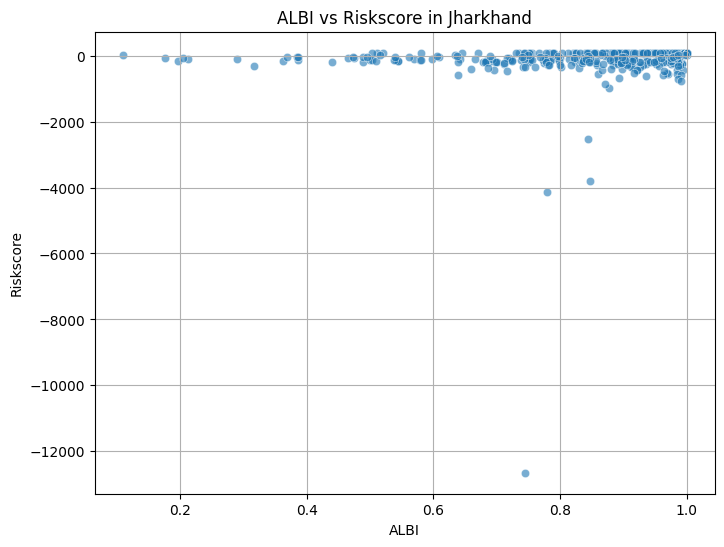

Bivariate analysis scatter plots for ALBI vs CES, DUR, BUR, and Riskscore displayed for Jharkhand.


In [270]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_jk_agg, x='ALBI', y='riskscore', alpha=0.6)
plt.title('ALBI vs Riskscore in Jharkhand')
plt.xlabel('ALBI')
plt.ylabel('Riskscore')
plt.grid(True)
plt.show()

print("Bivariate analysis scatter plots for ALBI vs CES, DUR, BUR, and Riskscore displayed for Jharkhand.")

In [271]:
numerical_age_cols = ['age_0_5', 'age_5_17', 'age_18_greater', 'demo_age_5_17', 'demo_age_17_', 'bio_age_5_17', 'bio_age_17_']
correlation_matrix_jk = df_merged_jk[numerical_age_cols].corr()

print("Correlation Matrix for Jharkhand:")
print(correlation_matrix_jk)

Correlation Matrix for Jharkhand:
                 age_0_5  age_5_17  age_18_greater  demo_age_5_17  \
age_0_5         1.000000  0.891953        0.476288       0.095815   
age_5_17        0.891953  1.000000        0.499898       0.063719   
age_18_greater  0.476288  0.499898        1.000000       0.028500   
demo_age_5_17   0.095815  0.063719        0.028500       1.000000   
demo_age_17_    0.045492  0.029423        0.012725       0.886093   
bio_age_5_17    0.095075  0.075662        0.082168       0.477660   
bio_age_17_     0.083492  0.066665        0.084412       0.496943   

                demo_age_17_  bio_age_5_17  bio_age_17_  
age_0_5             0.045492      0.095075     0.083492  
age_5_17            0.029423      0.075662     0.066665  
age_18_greater      0.012725      0.082168     0.084412  
demo_age_5_17       0.886093      0.477660     0.496943  
demo_age_17_        1.000000      0.473732     0.515351  
bio_age_5_17        0.473732      1.000000     0.890990  
bio_age

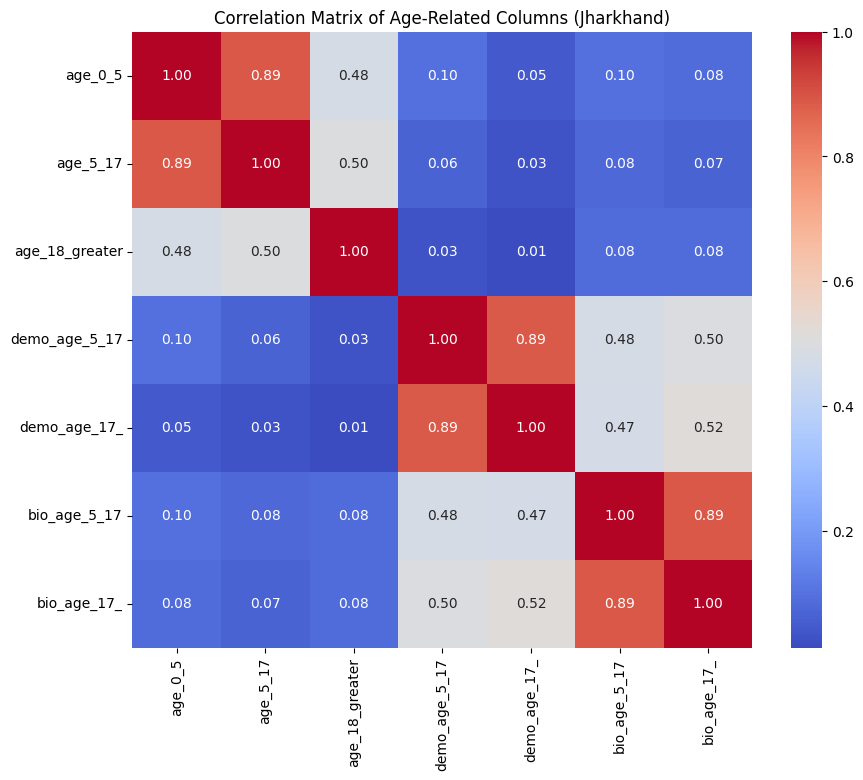

Correlation matrix heatmap for age-related columns displayed for Jharkhand.


In [272]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_jk, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Age-Related Columns (Jharkhand)')
plt.show()

print("Correlation matrix heatmap for age-related columns displayed for Jharkhand.")

In [273]:
age_cols_to_group = ['age_0_5', 'age_5_17', 'age_18_greater', 'demo_age_5_17', 'demo_age_17_', 'bio_age_5_17', 'bio_age_17_']
df_jk_district_mean = df_merged_jk.groupby('district')[age_cols_to_group].mean().reset_index()

print("District-wise average age-related data for Jharkhand:")
print(df_jk_district_mean.head())
print(df_jk_district_mean.info())

df_jk_district_mean['total_avg_age'] = df_jk_district_mean[age_cols_to_group].sum(axis=1)
df_jk_district_mean_top10 = df_jk_district_mean.nlargest(10, 'total_avg_age')

df_jk_district_mean_melted = df_jk_district_mean_top10.melt(
    id_vars=['district'],
    value_vars=age_cols_to_group,
    var_name='Age Group',
    value_name='Average Count'
)

District-wise average age-related data for Jharkhand:
   district   age_0_5  age_5_17  age_18_greater  demo_age_5_17  demo_age_17_  \
0    Bokaro  0.628263  0.471928        0.003225       0.566274      9.387763   
1  Bokaro *  0.117647  0.000000        0.000000       0.000000      0.000000   
2    Chatra  2.598811  2.195791        0.023330       2.309698     27.171089   
3  Chatra *  0.142857  0.000000        0.000000       0.000000      0.000000   
4   Deoghar  1.472779  1.430314        0.041594       0.949260     14.725174   

   bio_age_5_17  bio_age_17_  
0      6.393509    10.044955  
1      0.058824     0.823529  
2     22.724154    26.381976  
3      0.000000     0.857143  
4      9.657230    11.483232  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        37 non-null     object 
 1   age_0_5         37 non-null     float

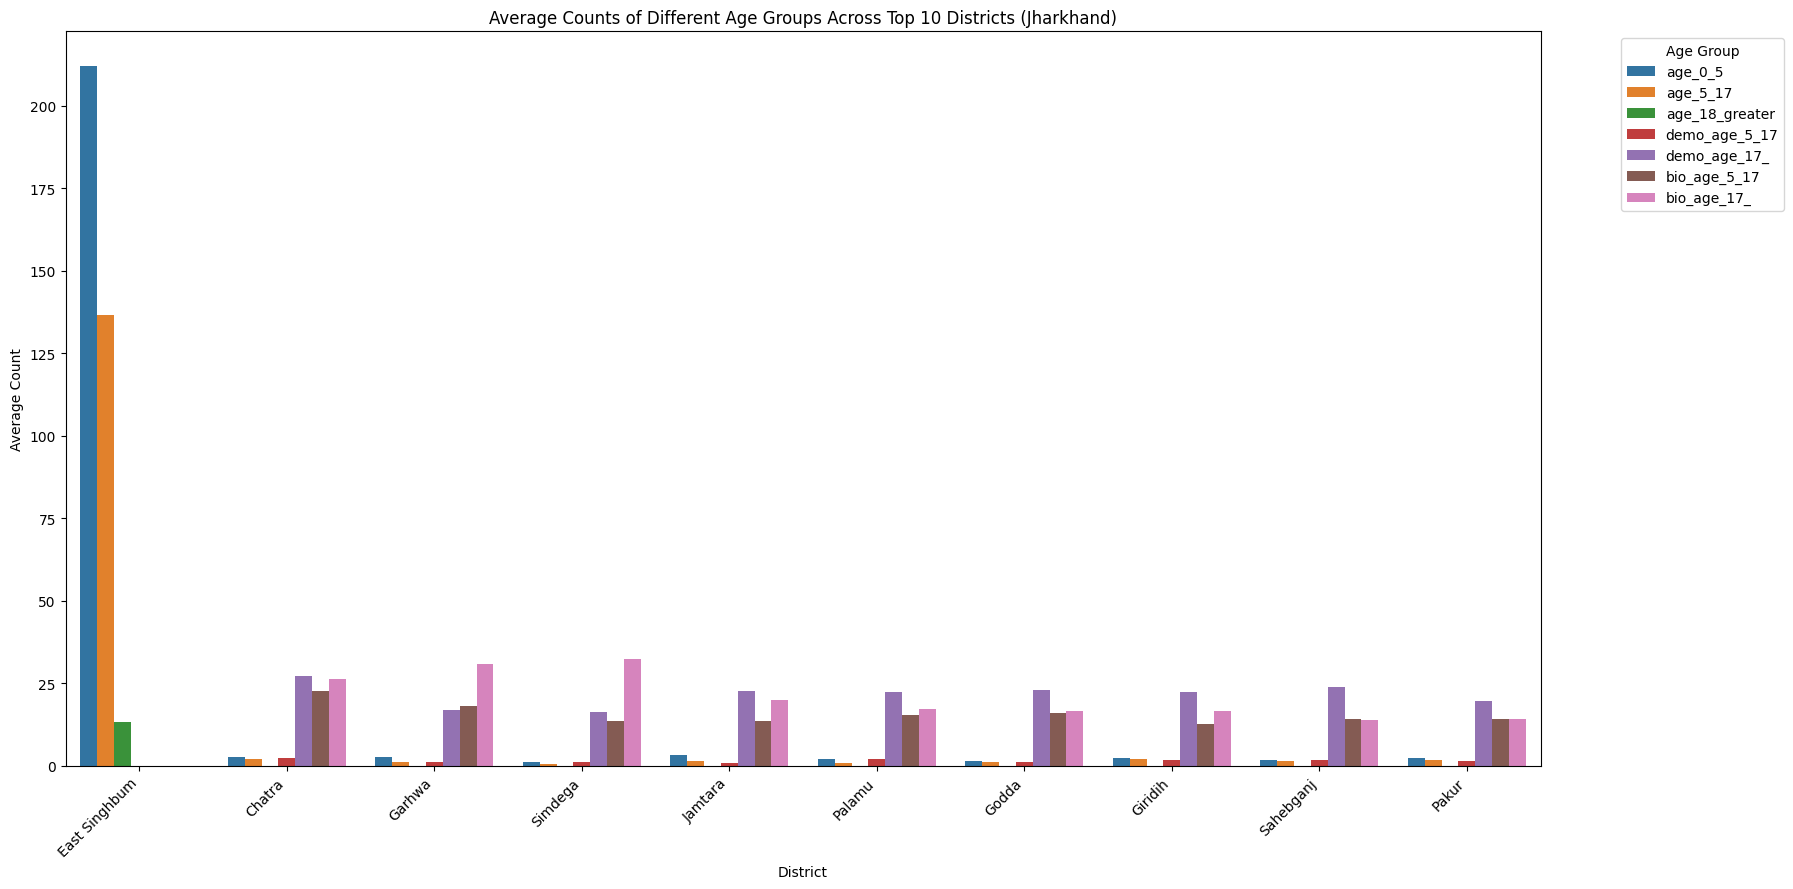

Insight: The grouped bar chart shows the distribution of average enrolment, demographic, and biometric counts across the top 10 districts in Jharkhand, highlighting which districts have higher overall activity and the relative contribution of each age group.


In [274]:
plt.figure(figsize=(18, 9))
sns.barplot(data=df_jk_district_mean_melted, x='district', y='Average Count', hue='Age Group', palette='tab10')
plt.title('Average Counts of Different Age Groups Across Top 10 Districts (Jharkhand)')
plt.xlabel('District')
plt.ylabel('Average Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Insight: The grouped bar chart shows the distribution of average enrolment, demographic, and biometric counts across the top 10 districts in Jharkhand, highlighting which districts have higher overall activity and the relative contribution of each age group.")

Time-series aggregated data (sum of age-related columns per date) for Jharkhand:
        date  age_0_5  age_5_17  age_18_greater  demo_age_5_17  demo_age_17_  \
0 2025-03-01      0.0       0.0             0.0        19339.0      460646.0   
1 2025-03-27     12.0      25.0            18.0            0.0           0.0   
2 2025-04-01   2026.0    1496.0           184.0          303.0        2760.0   
3 2025-05-01      0.0       0.0             0.0          160.0        1613.0   
4 2025-05-20      0.0       0.0             0.0            0.0           0.0   

   bio_age_5_17  bio_age_17_  
0      142789.0     187497.0  
1           0.0          0.0  
2      185766.0     193196.0  
3       99271.0     133125.0  
4        3756.0       7096.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            232 non-null    datetim

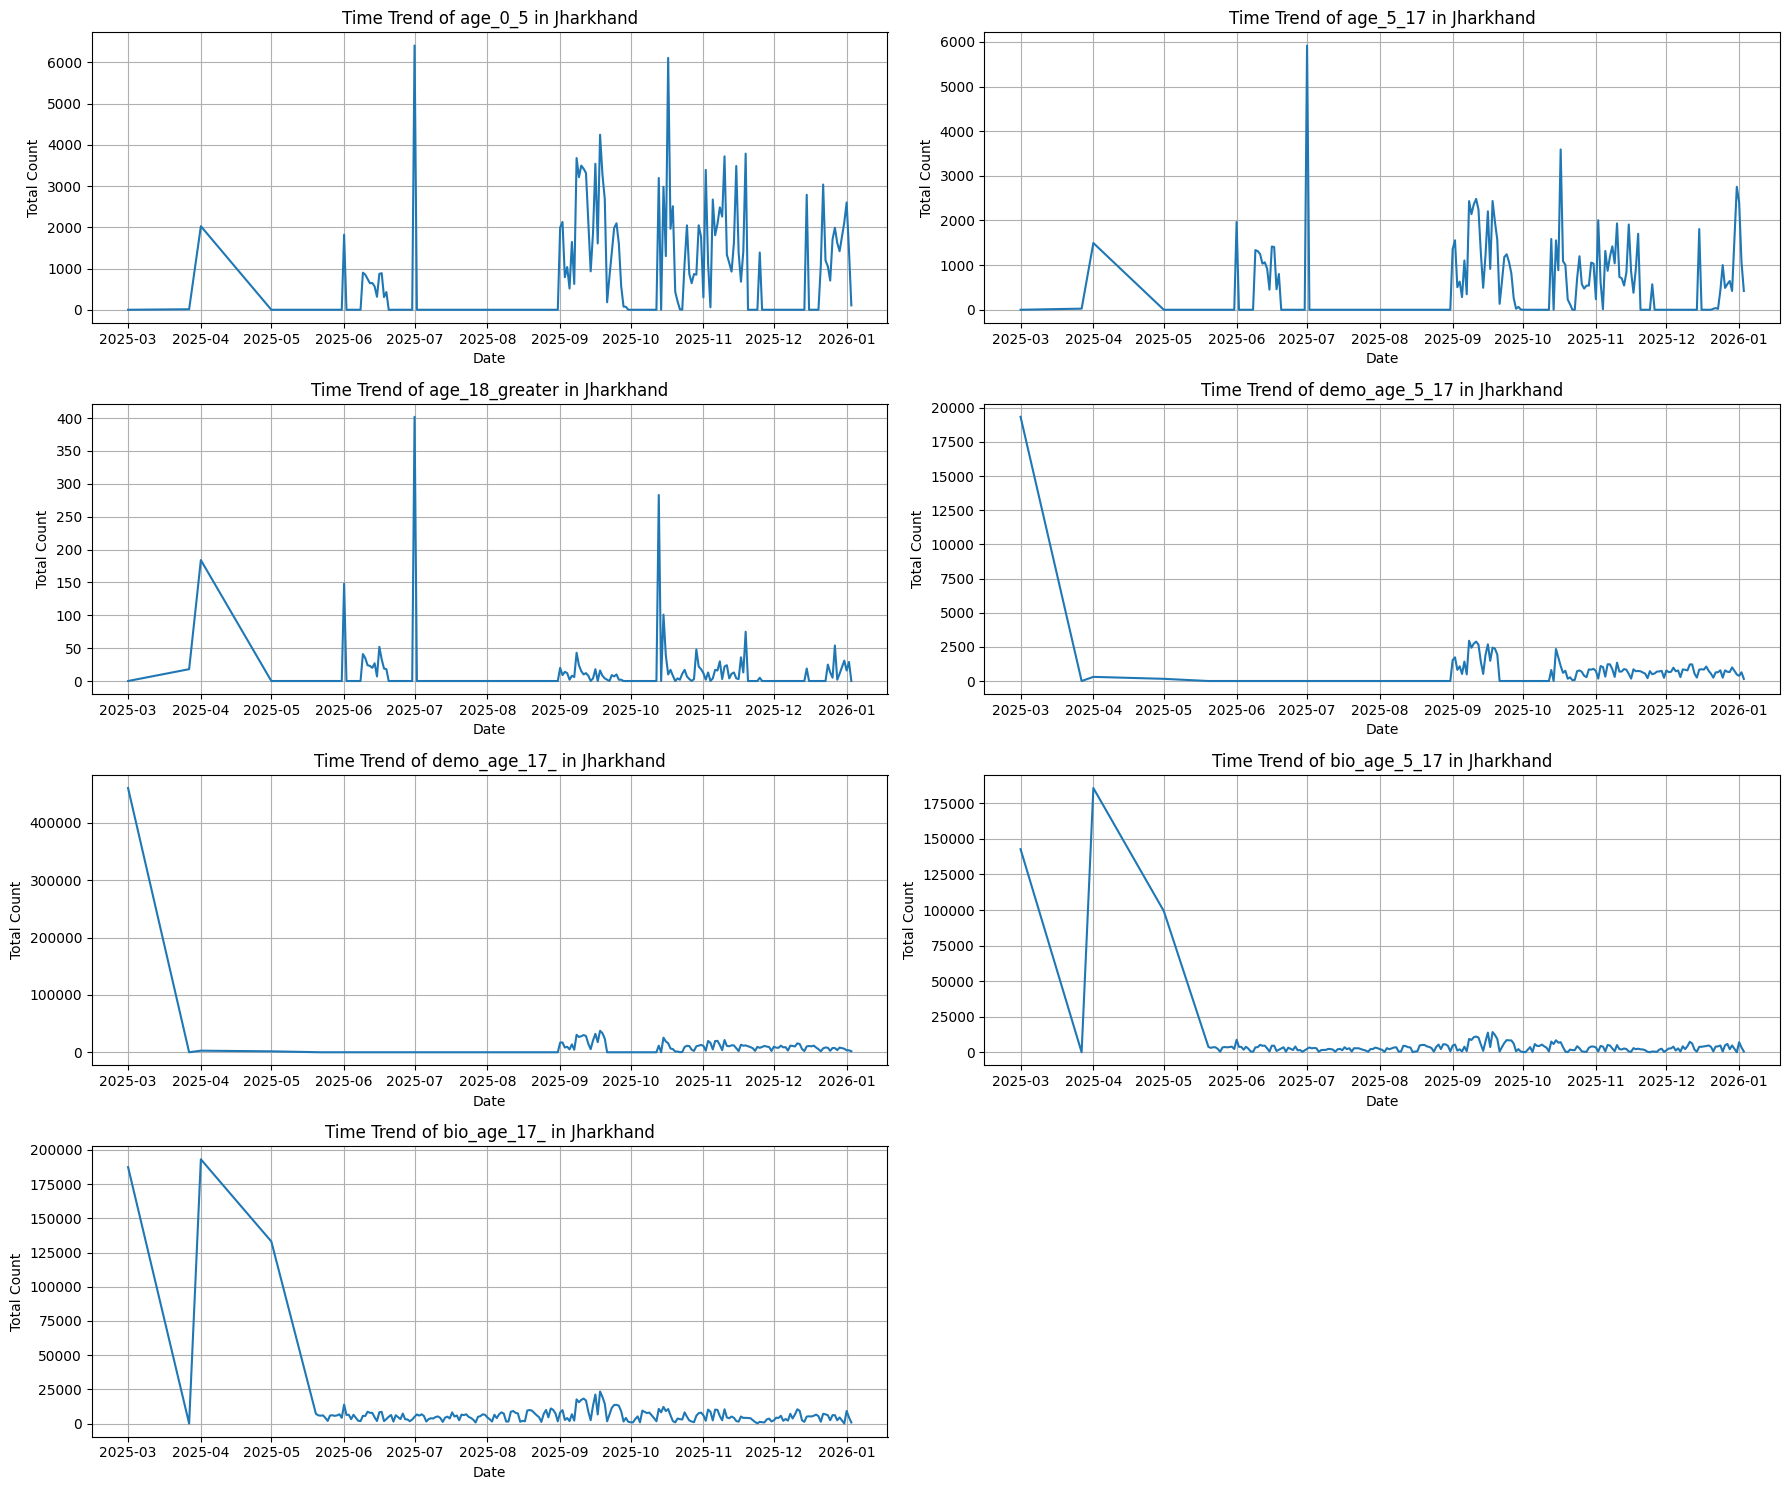

Insight: Line charts for each age-related column over time in Jharkhand provide a clear visualization of their temporal trends, allowing for the identification of periods of high/low activity or significant changes.


In [275]:
df_time_trend = df_merged_jk.groupby('date')[age_cols_to_group].sum().reset_index()

print("Time-series aggregated data (sum of age-related columns per date) for Jharkhand:")
print(df_time_trend.head())
print(df_time_trend.info())
plt.figure(figsize=(18, 15))
for i, col in enumerate(age_cols_to_group):
    plt.subplot(4, 2, i + 1) # Adjust subplot grid based on number of columns
    sns.lineplot(data=df_time_trend, x='date', y=col)
    plt.title(f'Time Trend of {col} in Jharkhand')
    plt.xlabel('Date')
    plt.ylabel('Total Count')
    plt.grid(True)
plt.tight_layout()
plt.show()

print("Insight: Line charts for each age-related column over time in Jharkhand provide a clear visualization of their temporal trends, allowing for the identification of periods of high/low activity or significant changes.")

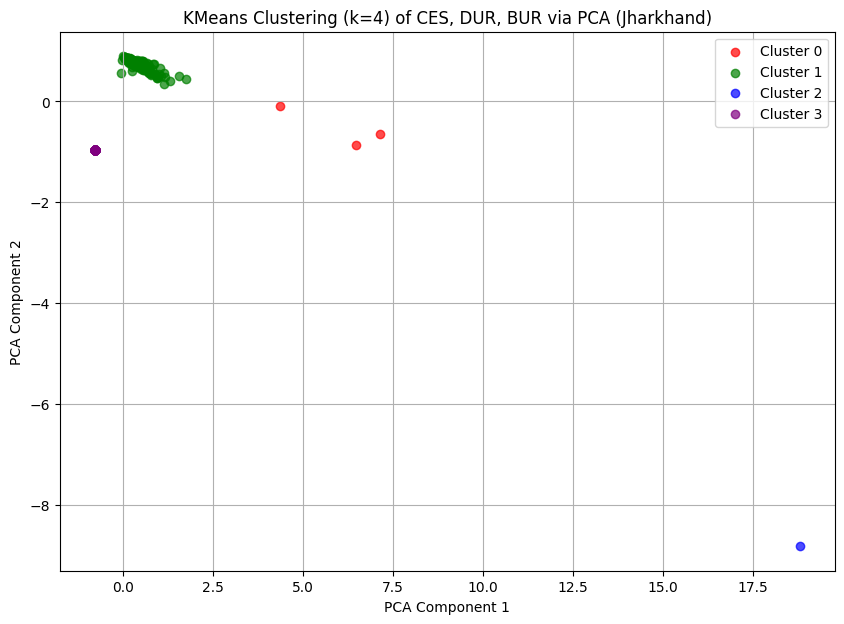

First 5 rows of df_jk_agg with 'clusterlabel' column:
   year  month      state district  age_0_5  age_5_17  age_18_greater  \
0  2025      3  Jharkhand   Bokaro      0.0       0.0             0.0   
1  2025      3  Jharkhand   Chatra      0.0       0.0             0.0   
2  2025      3  Jharkhand  Deoghar     12.0      25.0            18.0   
3  2025      3  Jharkhand  Dhanbad      0.0       0.0             0.0   
4  2025      3  Jharkhand    Dumka      0.0       0.0             0.0   

   demo_age_5_17  demo_age_17_  bio_age_5_17  ...     Bnorm   stdnorm  \
0          823.0       37376.0        3629.0  ...  0.305285  0.354511   
1          752.0       15325.0        5091.0  ...  0.311446  0.210191   
2          723.0       23244.0        5230.0  ...  0.282876  0.255491   
3         1241.0       39920.0        7080.0  ...  0.619914  0.478986   
4          826.0       19417.0        8376.0  ...  0.393228  0.265017   

       ALBI  Enormrisk  CESrisknorm  DURrisknorm  BURrisknorm  ALBIr

In [276]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 1. Select the columns for clustering
features_for_clustering = df_jk_agg[['CES', 'DUR', 'BUR']]

# 2. Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# 3. Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # Added n_init=10 for newer sklearn versions
kmeans.fit(scaled_features)

# 4. Add the cluster labels to df_jk_agg
df_jk_agg['clusterlabel'] = kmeans.labels_

# 5. Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(scaled_features)

# Create a DataFrame for PCA components for easier plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['clusterlabel'] = df_jk_agg['clusterlabel']

# 6. Generate a PCA scatter plot to visualize these clusters
plt.figure(figsize=(10, 7))
colors = ['red', 'green', 'blue', 'purple']

for i in range(4):
    plt.scatter(
        pca_df[pca_df['clusterlabel'] == i]['PCA Component 1'],
        pca_df[pca_df['clusterlabel'] == i]['PCA Component 2'],
        c=colors[i],
        label=f'Cluster {i}',
        alpha=0.7
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering (k=4) of CES, DUR, BUR via PCA (Jharkhand)')
plt.legend()
plt.grid(True)
plt.show()

print("First 5 rows of df_jk_agg with 'clusterlabel' column:")
print(df_jk_agg.head())

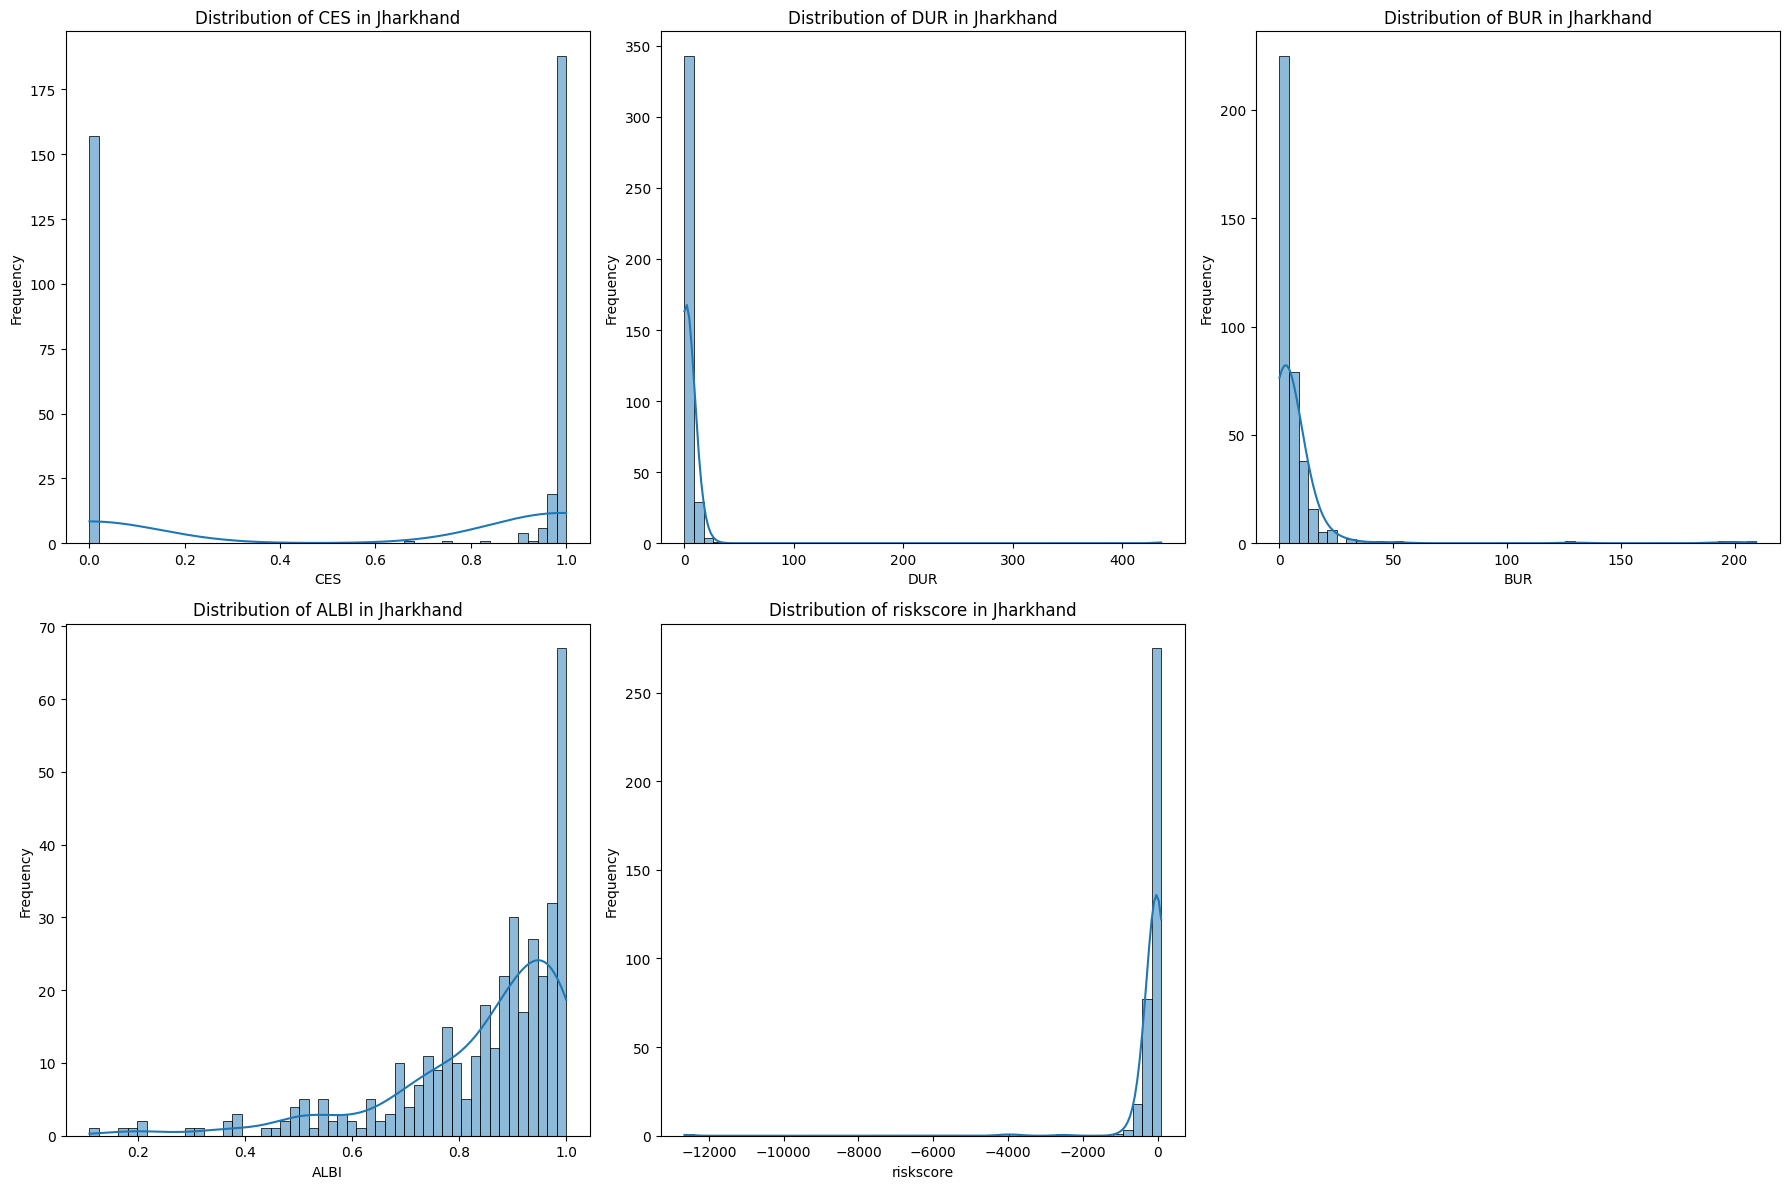

Histograms for CES, DUR, BUR, ALBI, and riskscore in Jharkhand displayed.


In [277]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_to_plot = ['CES', 'DUR', 'BUR', 'ALBI', 'riskscore']

plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_jk_agg[metric], bins=50, kde=True)
    plt.title(f'Distribution of {metric} in Jharkhand')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Histograms for CES, DUR, BUR, ALBI, and riskscore in Jharkhand displayed.")

In [278]:
import pandas as pd

# 1. Find the latest year and month
latest_year = df_jk_agg['year'].max()
latest_month = df_jk_agg[df_jk_agg['year'] == latest_year]['month'].max()

print(f"Latest reporting period: Year {latest_year}, Month {latest_month}")

# 2. Filter df_jk_agg for the latest year and month
df_latest_month_jk = df_jk_agg[(df_jk_agg['year'] == latest_year) & (df_jk_agg['month'] == latest_month)].copy()

# Metrics to analyze
metrics = ['CES', 'DUR', 'BUR', 'ALBI', 'riskscore']

# 3. For each metric, print top 10 and bottom 10 districts
for metric in metrics:
    print(f"\n--- Metric: {metric} ---")

    # Top 10 districts
    # For riskscore, top 10 implies highest risk, so ascending=False
    # For ALBI, top 10 implies best balance, so ascending=False
    # For CES, DUR, BUR, top 10 implies best performance, so ascending=False
    top_10 = df_latest_month_jk.sort_values(by=metric, ascending=False).head(10)
    print(f"\nTop 10 Districts by {metric} (Year {latest_year}, Month {latest_month}):")
    print(top_10[['district', metric]].to_string(index=False))

    # Bottom 10 districts
    # For riskscore, bottom 10 implies lowest risk, so ascending=True
    # For ALBI, bottom 10 implies least balance, so ascending=True
    # For CES, DUR, BUR, bottom 10 implies worst performance, so ascending=True
    bottom_10 = df_latest_month_jk.sort_values(by=metric, ascending=True).head(10)
    print(f"\nBottom 10 Districts by {metric} (Year {latest_year}, Month {latest_month}):")
    print(bottom_10[['district', metric]].to_string(index=False))

Latest reporting period: Year 2026, Month 1

--- Metric: CES ---

Top 10 Districts by CES (Year 2026, Month 1):
      district  CES
        Bokaro  1.0
        Garhwa  1.0
      Garhwa *  1.0
East Singhbhum  1.0
         Godda  1.0
       Kodarma  1.0
     Hazaribag  1.0
         Gumla  1.0
       Simdega  1.0
       Ramgarh  1.0

Bottom 10 Districts by CES (Year 2026, Month 1):
       district      CES
         Pakaur 0.833333
Purbi Singhbhum 0.976190
         Khunti 0.979592
        Giridih 0.983696
        Koderma 0.983784
        Deoghar 0.988701
      Sahebganj 0.992105
          Dumka 0.992308
     Hazaribagh 0.992933
        Dhanbad 0.993377

--- Metric: DUR ---

Top 10 Districts by DUR (Year 2026, Month 1):
           district      DUR
          Hazaribag 2.720000
            Kodarma 2.647059
    Purbi Singhbhum 2.404762
              Pakur 2.367089
            Simdega 2.087719
            Palamau 1.944444
Seraikela-kharsawan 1.938462
         Hazaribagh 1.872792
              

## Summary:

### Data Analysis Key Findings

*   **Data Integration and Preprocessing**: Enrolment, demographic, and biometric datasets for Jharkhand were successfully loaded, their 'date' columns converted to datetime objects, and merged into a single DataFrame (`df_merged_jk`). Missing numerical values were imputed with 0.
*   **Key Metric Calculation**: Essential metrics including `totalenrolments`, `childenrolments`, `totaldemoupdates`, `totalbioupdates`, `CES` (Child Enrolment Score), `DUR` (Demographic Update Rate), `BUR` (Biometric Update Rate), `ALBI` (Aadhaar Lifecycle Balance Index), and a `riskscore` were computed. `ALBI` was clipped between 0 and 1.
*   **Anomaly in Risk Score**: A significant number of negative `riskscore` values were observed across districts, consistent with findings in other states, indicating a potential issue with the metric's definition or calculation that needs further review for interpretability and actionability. For instance, Simdega had a `riskscore` of -190.18, and Koderma and Jamtara showed negative scores of -56.7 and -54.6 respectively in the latest period.
*   **Monthly Activity Trends**: Time-series plots revealed monthly fluctuations in total enrolments, demographic updates, and biometric updates, suggesting varying activity levels over time.
*   **Correlation Analysis**: Strong positive correlations were found within age groups for enrolment (e.g., `age_0_5` and `age_5_17`) and update categories (e.g., `demo_age_5_17` and `demo_age_17_`), while correlations between enrolment and update figures were generally weaker.
*   **District Performance (Latest Reporting Period: Year 2026, Month 1)**:
    *   **CES (Child Enrolment Score)**: Most districts like Bokaro, Garhwa, and East Singhbhum achieved a perfect score of 1.0, indicating high child enrolment. However, districts like Pakaur (0.833) and Deoghar (0.97) had slightly lower scores.
    *   **DUR (Demographic Update Rate)**: Koderma (5.25) and Jamtara (4.38) showed the highest demographic update activity relative to enrolments. Conversely, several districts (e.g., Simdega, Godda, Garhwa, Pashchimi Singhbhum with 0.208) recorded 0.0 or very low `DUR`s, suggesting no or minimal demographic updates.
    *   **BUR (Biometric Update Rate)**: Koderma (7.18) and Jamtara (6.07) also led in biometric update activity. Similar to `DUR`, districts like Simdega, Godda, Garhwa, and Sahibganj (1.29) had 0.0 or minimal `BUR`s.
    *   **ALBI (Aadhaar Lifecycle Balance Index)**: Simdega (1.0), Godda (0.98), and Garhwa (0.97) demonstrated the best balance in Aadhaar lifecycle activities. Koderma (0.33) and Jamtara (0.43) had the lowest balance, indicating potential imbalances.
*   **Clustering Analysis**: Districts were grouped into four distinct clusters based on their `CES`, `DUR`, and `BUR` metrics, providing insights into different operational profiles and performance levels across Jharkhand.

### Insights or Next Steps

*   **Refine Risk Score Calculation**: The calculation of the `riskscore` metric should be critically reviewed and potentially adjusted to ensure it consistently yields meaningful positive values within a defined range, enhancing its utility for identifying high-risk areas.
*   **Targeted Interventions**: Focus interventions on districts exhibiting low `DUR` and `BUR` values, and those with imbalanced `ALBI` scores (e.g., Koderma and Jamtara), to improve overall Aadhaar data quality and lifecycle management. The identified clusters can guide tailored strategies for different district profiles.
